In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from skimage.measure import structural_similarity as ssim
import glob
import matplotlib.gridspec as gridspec
%matplotlib inline

In [55]:
class ExtractTiles():
    
    def __init__(self,image, show = False, automatic = True, save = False):
        self.color_image = image
        self.image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        self.show = show
        #self.show_image(self.image,"original image")
        self.save = save
        self.len_of_halfDiagnol = (np.sqrt (70**2 + 14 **2) )/2
        if automatic == True:
            self.main()
        
    def main(self):
        self.get_contours()
        self.extract_line()
        self.crop_image()
        self.get_tile_contour()
        self.find_corners()
        #self.sort_points()
        self.get_final_corner()
        self.homography()
        self.get_tiles()
        
    def slope_function(self,y1,y2,x1,x2):
        if x2 != x1:
            return float(y2-y1)/float(x2-x1)
        else:
            return 0.

    def distance_function(self,x1,x2,y1,y2):
        return np.sqrt((x2-x1)**2+(y2-y1)**2)
        
    def show_image(self,image,name):
        cv2.imshow(name,image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    def plot_points(self,image,points,title,show_line = False):
        if show_line == True:
            cv2.line(image,(points[0,0],points[0,1]),(points[-1,0],points[-1,1]),(255,0,0),1)
        for p in points:
            cv2.circle(image,(p[0],p[1]),3,(0,0,255),-1)
            
        #print points[0,:],points[-1,:]
        if self.save == True:
            cv2.imwrite('line.jpg',image)
        self.show_image(image,title)
        
    def get_pixelPerCM(self):
        #Pixel per centimeter is calculated based on the fact that the distance between the
        #cavity tile is 14cm 
        
        a = self.final_five_points
        #a = np.array(a)
        b = np.zeros(len(a)-1)
        for i in range (len(a)-1) :
            b[i]= abs (a[i][0]-a[i+1][0])
            
        #average distance between the center of the cavity tiles is divided by 14
        
        self.pixelPerCM = np.mean(b)/14
        
        
    def get_contours(self,show = False):
        edges = cv2.Canny(self.image,120,500)
        _, contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        objects = np.zeros([self.image.shape[0],self.image.shape[1],3], 'uint8')
        self.center_points = []
        for c in contours:
            area = cv2.contourArea(c)
            if area >= 1 and area <= 100000:
                cv2.drawContours(objects,[c],-1,(255,0,0),-1)
                M = cv2.moments(c)
                cx = int( M['m10']/M['m00'])
                cy = int( M['m01']/M['m00'])
                self.center_points.append((cx,cy))
                cv2.circle(objects,(cx,cy),4,(0,0,255),-1)
        if self.save == True:
            cv2.imwrite('cavitycontours.jpg',objects)
        if show == True or self.show == True:
            self.show_image(objects,"Extracted Contours")
    
    def extract_line(self,show=False):
        self.center_points = list(set(self.center_points))
        length = len(self.center_points)
        points = []
        for i in xrange(length):
            for j in xrange(length):

                if j> i:
                    distance = self.distance_function(self.center_points[j][0],self.center_points[i][0],self.center_points[j][1],self.center_points[i][1])

                    if distance <= 12:
                        points.append(self.center_points[j])
        
        for j in points:
            try:
                self.center_points.remove(j)
            except:
                pass
            
        self.center_points = np.array(self.center_points)
        length = len(self.center_points)
        x,y,x1,y1,m = sp.symbols('x,y,x1,y1,m')
        eq = (y-y1)-(m*(x-x1))  
        min_error = 1000
        for i in xrange(length):
            for j in xrange(length):
                if j>i:
                    #print center_points[j,0],center_points[i,0],center_points[j,1],center_points[i,1]
                    slope = self.slope_function(self.center_points[j,1],self.center_points[i,1],self.center_points[j,0],self.center_points[i,0])

                    eq1 = eq.subs({y1:self.center_points[i,1],x1:self.center_points[i,0],m:slope})
                    counter = 0
                    points = []
                    error =0
                    for k in xrange(len(self.center_points)):
                        dist = eq1.subs({x:self.center_points[k,0],y:self.center_points[k,1]})
                        
                        if abs(dist) <= 10:
                            error += abs(dist)
                            #print dist
                            counter += 1
                            points.append(self.center_points[k])

                    if counter >= 5:    
                        min_error = min(min_error,error)
                        if min_error == error:
                            self.final_five_points = points
                        im2 = im.copy()
                        #print distlist
                        for it,p in enumerate(points):
                            cv2.circle(im2,(p[0],p[1]),4,(0,0,255),-1)
                            
        self.final_five_points =  np.array(self.final_five_points)[np.array(self.final_five_points)[:,0].argsort()]
        self.get_pixelPerCM()
        if show == True or self.show == True:
            self.plot_points(im,self.final_five_points,"Final five points",show_line= True)
            
    def crop_image(self,show = False):
        dist = 0
        for i in xrange(len(self.final_five_points)-1):
            dist += self.distance_function(self.final_five_points[i,0],self.final_five_points[i+1,0],self.final_five_points[i,1],self.final_five_points[i+1,1])
        dist = int(dist/(len(self.final_five_points)-1))*2/3+5
        x_min = self.final_five_points[0,0]-dist-10 if self.final_five_points[0,0]-dist-10 > 0 else 0
        x_max = self.final_five_points[-1,0]+dist+10 if self.final_five_points[-1,0]+dist < self.image.shape[1] else self.image.shape[1]
        y_min = min(self.final_five_points[:,1])-dist if min(self.final_five_points[:,1])-dist > 0 else 0
        y_max = max(self.final_five_points[:,1])+dist if max(self.final_five_points[:,1])+dist < self.image.shape[0] else self.image.shape[0]
        self.crop= self.image[y_min:y_max,x_min:x_max]
        if self.save == True:        
            cv2.imwrite('cropped.jpg',self.crop)
        if show == True  or self.show == True:
            self.show_image(self.crop,"Cropped Image")
            
    def get_tile_contour(self,show = False):
        adapt = cv2.adaptiveThreshold(self.crop, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,51,1)
        _, contours, hierarchy = cv2.findContours(adapt,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        self.objects = np.zeros([adapt.shape[0],adapt.shape[1],3], 'uint8')
        center_points = []
        detected_contours = 0
        for c in contours:
            area = cv2.contourArea(c)
            shape = self.detect(c)
            
            if area >= 5000 and area <= 100000 and shape != "unidentified":
                detected_contours += 1
                print detected_contours,":",shape
                cv2.drawContours(self.objects,[c],-1,(255,255,0),-1)
                epsilon = 0.005*cv2.arcLength(c,True)
                self.corner_points = np.float32(np.squeeze(cv2.approxPolyDP(c,epsilon,True)))
                M = cv2.moments(c)
                cx = int( M['m10']/M['m00'])
                cy = int( M['m01']/M['m00'])
                center_points.append([cx,cy])
        
        center_points = np.array(center_points)
        #print "center points",center_points
        
        if detected_contours == 1:
            self.tile_center_point= center_points
            self.tile_center_point= self.tile_center_point.flatten()
        else:
            self.tile_center_point= np.mean(center_points,axis=0,dtype=int)
            #self.tile_center_point = int(self.tile_center_point)
            
        print "Center of the tile is",self.tile_center_point
        if self.save == True:        
            cv2.imwrite('5tiles.jpg',self.objects)
        if show == True  or self.show == True:
            cv2.circle(self.objects,(self.tile_center_point[0],self.tile_center_point[1]),4,(0,255,255),-1)
            self.show_image(self.objects,"Contour of Tiles")
            
    def find_corners(self,show = False):
        #find all possible corner points
        gray = cv2.cvtColor(self.objects,cv2.COLOR_BGR2GRAY)
        dst = cv2.cornerHarris(gray,7,21,0.1)
        ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
        dst = np.uint8(dst)

        ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
        corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
        
        res = np.hstack((centroids,corners))
        res = np.int0(res)
        
        self.objects[res[:,3],res[:,2]] = [0,0,255]
        self.corners = np.vstack((res[:,2],res[:,3])).T
        
        if self.save == True:   
            cv2.imwrite('Corners.jpg',self.objects[0:50,0:50])
        if show == True  or self.show == True:
            self.plot_points(self.objects,self.corners,"All corner Points")
            #self.show_image(self.objects,"Corners")
        
    def sort_points(self):
        
        self.corner_points = self.corner_points[self.corner_points[:,0].argsort()]
        self.corners = self.corners[self.corners[:,0].argsort()]
        if self.corners[0,1] < self.corners[1,1]:
            p1 = self.corners[0,:]
            p3 = self.corners[1,:]
        else:
            p1 = self.corners[1,:]
            p3 = self.corners[0,:]
            
        if self.corners[3,1] < self.corners[4,1]:
            p4 = self.corners[4,:]
            p2 = self.corners[3,:]
        else:
            p4 = self.corners[3,:]
            p2 = self.corners[4,:]
        
        self.final_corner_points = np.float32(np.vstack((p1,p2,p3,p4)))
        
        if self.show == True:
            self.plot_points(self.objects,self.final_corner_points,"Final corner points")
            
    def get_final_corner(self):
        dist_btw_ctr_corner = self.len_of_halfDiagnol * self.pixelPerCM
        #print "ditance between center and the corners in pixel", dist_btw_ctr_corner
        final_corner_points = []
        for pt in self.corners:
            
            dist = self.distance_function(pt[0],self.tile_center_point[0],pt[1],self.tile_center_point[1])
            
            #look for the points that lie at the distance of approximated diagnol value with 10% tolerance
            if dist < 1.3*dist_btw_ctr_corner and dist > 0.7*dist_btw_ctr_corner:
                final_corner_points.append([pt[0],pt[1]])
            
        self.final_corner_points = np.array(final_corner_points)
        self.final_corner_points = np.float32(self.final_corner_points)
        if len (self.final_corner_points) == 4:
            print "Four corner points are", self.final_corner_points
            if self.show == True:
                self.plot_points(self.crop.copy(),self.final_corner_points,"Final corner points")
                
        else: 
            self.sort_points()
        
    def homography(self,show = False):
        #print self.corner_points
        pts2 = np.float32([[0,0],[1000,0],[0,200],[1000,200]])
        M = cv2.getPerspectiveTransform(self.final_corner_points,pts2)
        self.dst = cv2.warpPerspective(self.crop,M,(1000,200))
        ret, thresh = cv2.threshold(self.dst, 120, 255, cv2.THRESH_BINARY_INV)
        thresh_adapt = cv2.adaptiveThreshold(self.dst, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,115,1)
        if self.save == True:        
            cv2.imwrite('homography.jpg',self.dst)
        if show == True  or self.show == True:
            self.show_image(thresh_adapt,"Transformed Tiles")
        
    def get_tiles(self,show = False):
        tiles = []
        for i in xrange(5):
            self.show_image(self.dst[0:200,200*i:200*(i+1)],"Extracted Tile #"+str(i+1))
            cv2.imwrite('tile'+str(i)+'.jpg',self.dst[0:200,200*i:200*(i+1)])
            tiles.append(self.dst[0:200,200*i:200*(i+1)])
        self.tiles = np.array(tiles)
        return self.tiles
    
    def detect(self, c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.01 * peri, True)

        # if the shape has 4 vertices, it is either a square or
        # a rectangle
        if len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)

            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"

        # return the name of the shape
        return shape
    

In [33]:
class ShapeDetector:
    def __init__(self):
        pass

    def detect(self, c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        
        # if the shape is a triangle, it will have 3 vertices
        if len(approx) == 3:
            shape = "triangle"

        # if the shape has 4 vertices, it is either a square or
        # a rectangle
        elif len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)

            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"

        # if the shape is a pentagon, it will have 5 vertices
        elif len(approx) == 5:
            shape = "pentagon"

        # otherwise, we assume the shape is a circle
        else:
            shape = "circle"

        # return the name of the shape
        return shape

In [34]:
class Find_objects():
    
    def __init__(self,CavityTiles,show = False, input_image = None,auto = True):
        print "Initiating the finding objects process"
        self.tiles = CavityTiles
        self.input_image = input_image
        self.show = show
        self.no_of_tiles = np.shape(self.tiles)[0]
        if auto == True:
            self.find_object_name()
            self.print_result()        
        
    def show_image(self,image,name):
        cv2.imshow(name,image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    def mse(self,imageA, imageB):
        # the 'Mean Squared Error' between the two images is the
        # sum of the squared difference between the two images;
        # NOTE: the two images must have the same dimension

        err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
        err /= float(imageA.shape[0] * imageA.shape[1])

        # return the MSE, the lower the error, the more "similar"
        # the two images are
        return err
    
    def compare_images(self, imageA, imageB):

        #imageA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
        imageB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
        
        #Converting both images into same size
        imageA = cv2.resize(imageA,(300,300))
        imageB = cv2.resize(imageB,(300,300))
        
        #Applying threshold, so that important features such as shape and size of
        #of the cavity is highlighted
        ret,imageA = cv2.threshold(imageA,127,255,cv2.THRESH_BINARY)
        ret,imageB = cv2.threshold(imageB,200,255,cv2.THRESH_BINARY)
        
        #Applying median blur to get rid of salt and pepper noise
        imageA = cv2.medianBlur(imageA,5)
        imageB = cv2.medianBlur(imageB,5)
        
        # compute the mean squared error and structural similarity
        # index for the images
        m = self.mse(imageA, imageB)
        s = ssim(imageA, imageB)
        
        return m,s
    
    def compare_this_image_with_database(self,img):
        images = [cv2.imread(file) for file in glob.glob("20171219_Dataset/*.jpg")]

        Image_names = glob.glob("20171219_Dataset/*.jpg")

        for i in range (len(Image_names)):
            Image_names[i]=Image_names[i].replace("20171219_Dataset/","")
            Image_names[i]=Image_names[i].replace(".jpg","")

        size = len(images)

        m=np.zeros(size,float)
        s=np.zeros(size,float)
        for j in range(len(images)):
            m1,s1 = self.compare_images(img,images[j])
            m[j]=int(m1)
            s[j]=round (s1,4)

        bestmatch_msi = np.argsort(m)
        bestmatch_ssim = np.argsort(s)

        print "Output:"
        print "The bestmatch from the MSI method"
        print "1.", Image_names[bestmatch_msi[0]],m[bestmatch_msi[0]]
        print "2.", Image_names[bestmatch_msi[1]],m[bestmatch_msi[1]]
        print "3.", Image_names[bestmatch_msi[2]],m[bestmatch_msi[2]]
        print "The bestmatch from the SSIM method"
        print "1:",Image_names[bestmatch_ssim[-1]],s[bestmatch_ssim[-1]]
        print "2:",Image_names[bestmatch_ssim[-2]],s[bestmatch_ssim[-2]]
        print "3:",Image_names[bestmatch_ssim[-3]],s[bestmatch_ssim[-3]]
        print "----------------------------------------"
        img = cv2.resize(img,(300,300))
        images[bestmatch_msi[0]] = cv2.resize(images[bestmatch_msi[0]],(300,300))
        images[bestmatch_ssim[-1]] = cv2.resize(images[bestmatch_ssim[-1]],(300,300))
        if self.show == True:
            self.show_image(img,"Input")
            self.show_image( images[bestmatch_msi[0]],"MSE best match")
            self.show_image(images[bestmatch_ssim[-1]],"SSIM best match")

            
        return Image_names[bestmatch_ssim[-1]]
    
    def find_object_name(self):
        self.solution = []
        for i in range (self.no_of_tiles):
            tileName = self.compare_this_image_with_database(self.tiles[i])
            self.solution.append(tileName)
    
    def print_result(self):
        fig = plt.figure("Output")
        fig.set_size_inches(18.5, len (self.solution)*2)
        #lt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
        # show first image
        subplot_row = self.no_of_tiles  + 1
        subplot_row = int(subplot_row)
        subplot_col = 2
        
        if self.input_image != None:
            ax1 =  plt.subplot2grid((subplot_row,subplot_col), (0, 0))
            plt.imshow(self.input_image, cmap = plt.cm.gray)
            plt.title("Input image")
            plt.axis("off")
        
        for i in range (len (self.solution)):
            if i%2 == 0:
                posx = i+1
                posy = 0
            else:
                posy =1

            ax2 = plt.subplot2grid((subplot_row,subplot_col), (posx, posy))
            plt.imshow(self.tiles[i], cmap = plt.cm.gray)
            plt.title("Tile" + str(i) + ":" + self.solution[i])
            plt.axis("off") 
            

        plt.tight_layout()
        plt.show()
    

In [68]:
im = cv2.imread('Results/Third_set.jpg')
tiles = ExtractTiles(im,show=True)

1 : rectangle
2 : rectangle
Center of the tile is [250  65]


Initiating the finding objects process
Output:
The bestmatch from the MSI method
1. LargeNut_Vertical_90 556.0
2. Cylinder_Horizontal_90 2426.0
3. SmallNut_Vertical_90 2642.0
The bestmatch from the SSIM method
1: LargeNut_Vertical_90 0.9738
2: SmallNut_Vertical_90 0.9354
3: Cylinder_Vertical_00 0.9328
----------------------------------------
Output:
The bestmatch from the MSI method
1. ShortAluminiumProfile_Vertical_00 1380.0
2. LargeNut_Horizontal_00 2837.0
3. SmallNut_Horizontal_00 3108.0
The bestmatch from the SSIM method
1: ShortAluminiumProfile_Vertical_00 0.9449
2: SmallNut_Vertical_00 0.9221
3: LargeNut_Horizontal_00 0.9212
----------------------------------------
Output:
The bestmatch from the MSI method
1. SmallNut_Vertical_00 257.0
2. Cylinder_Vertical_00 1107.0
3. SmallNut_Horizontal_00 1147.0
The bestmatch from the SSIM method
1: SmallNut_Vertical_00 0.9855
2: Cylinder_Vertical_00 0.9646
3: SmallNut_Horizontal_00 0.9641
----------------------------------------
Output:
The b

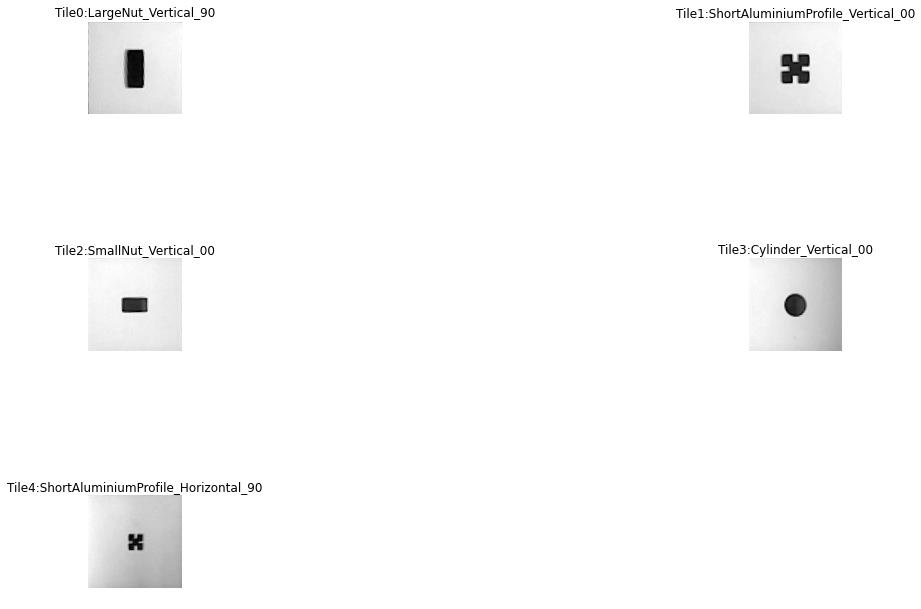

In [66]:
images = [cv2.imread(file) for file in glob.glob("Tiles/*.jpg")]
images = np.array(images)
images = images[:,:,:,1]


a = Find_objects(tiles.tiles,show= True)